In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
from skbio.stats.composition import ilr
from skbio.stats.composition import clr
from skbio.stats.composition import multiplicative_replacement
import seaborn as sns
from matplotlib import rcParams
sns.set()
sns.set(font_scale=1.5)

## Import Feature Count Cohort Dataframes

In [3]:
american_allStrains_FeatureDF = pd.read_csv('./DataFiles/Dataframes/functionalAnalysis/FeatureCounts/Filled_american_TIGRFam.csv')
american_allStrains_FeatureDF.set_index("SampleName", inplace=True)
american_allStrains_FeatureDF['Cohort'] = 'American'

indian_allStrains_FeatureDF = pd.read_csv('./DataFiles/Dataframes/functionalAnalysis/FeatureCounts/Filled_indian_TIGRFam.csv')
indian_allStrains_FeatureDF.set_index("SampleName", inplace=True)
indian_allStrains_FeatureDF['Cohort'] = 'Indian'


european_allStrains_FeatureDF = pd.read_csv('./DataFiles/Dataframes/functionalAnalysis/FeatureCounts/Filled_european_TIGRFam.csv')
european_allStrains_FeatureDF.set_index("SampleName", inplace=True)
european_allStrains_FeatureDF['Cohort'] = 'European'

japanese_allStrains_FeatureDF = pd.read_csv('./DataFiles/Dataframes/functionalAnalysis/FeatureCounts/Filled_japanese_TIGRFam.csv')
japanese_allStrains_FeatureDF.set_index("SampleName", inplace=True)
japanese_allStrains_FeatureDF['Cohort'] = 'Japanese'

In [4]:
#Concat all the nonNormalized Dataframes together to make 1 large dataframe (This contains Cohort)
allCohorts_allStrains_FeatureDF = pd.concat([american_allStrains_FeatureDF,indian_allStrains_FeatureDF,european_allStrains_FeatureDF,japanese_allStrains_FeatureDF])

#Normalize DataFrame
allCohorts_allStrains_FeatureDF2 = allCohorts_allStrains_FeatureDF.drop(columns=['Cohort']).copy()
allCohorts_allStrains_FeatureDF_Normalized = allCohorts_allStrains_FeatureDF2.div(allCohorts_allStrains_FeatureDF2.sum(axis=1), axis=0).copy()            

## Perform CLR Transformation

In [5]:
## Add a pseudocount to 0.0 value organisms in order to perform ILR transformations on dataframes (NORMALIZED)
from skbio.stats.composition import multiplicative_replacement
from skbio.stats.composition import clr
from tqdm import tqdm

#All strains
allCohorts_allStrains_FeatureDF_Normalized.fillna(0.0, inplace=True)
clr_allCohorts_allStrains_FeatureDF_Normalized = pd.DataFrame(columns=allCohorts_allStrains_FeatureDF_Normalized.columns, index=allCohorts_allStrains_FeatureDF_Normalized.index)

In [6]:
#ALL Strains
for row in tqdm(clr_allCohorts_allStrains_FeatureDF_Normalized.index):
    clr_allCohorts_allStrains_FeatureDF_Normalized.loc[row] = clr(np.array(allCohorts_allStrains_FeatureDF_Normalized.loc[row].replace(0.0, 1e-10)))

100%|██████████| 606/606 [02:12<00:00,  4.59it/s]


In [14]:
clr_allCohorts_allStrains_FeatureDF_Normalized['Cohort'] = allCohorts_allStrains_FeatureDF['Cohort'].copy()

## Run PCA

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def runPCA(dataframe, filename, title):
    pcaDF2 = dataframe.reset_index().drop("SampleName",axis=1).copy()
    pcaDF3 = pcaDF2.drop("Cohort", axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    import seaborn as sns
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    palette ={"American":'green', "European":'deepskyblue', "Indian":'violet', "Japanese":'orange'}

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1 ('+str("%.2f" % (100*pca.explained_variance_ratio_[0]))+"% variance)", labelpad=15)
    ax.set_ylabel('Principal Component 2 ('+str("%.2f" % (100*pca.explained_variance_ratio_[1]))+"% variance)", labelpad=15)
    ax.set_title('Principal Component Analysis (CLR - '+title+' )')

    targets = ['American','European','Indian', 'Japanese']

    colors = ['green','deepskyblue','violet','orange']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf ['Cohort'] == target
        ax.scatter(finalDf .loc[indicesToKeep, 'principal component 1']
                   , finalDf .loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='Cohorts')
    ax = sns.set(font_scale=1.5)
    plt.show()

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pullFeatureImportance(dataframe):
    
    pcaDF2 = dataframe.reset_index().drop("SampleName",axis=1).copy()
    pcaDF3 = pcaDF2.drop(columns=["Cohort"], axis=1).copy()
    features = pcaDF3.columns
    x = pcaDF3.loc[:, features].values
    y = pcaDF2.loc[:,['Cohort']].values
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2']).copy()
    finalDf = pd.concat([principalDf, pcaDF2[['Cohort']]], axis = 1).copy()
    
    return (pd.DataFrame(pca.components_,columns=pcaDF3.columns,index = ['PC-1','PC-2']))

In [17]:
def pullTopFeatures(df, pc):
    tempDictionary = {"TIGRFAM":[], "Feature_Importance":[]}
    df1 = df.copy()
    df2 = df1.T.reindex(featureImportanceDF_Pfam.T[pc].abs().sort_values(ascending=False).index).copy()
    posCount = 0
    negCount = 0
    
    for row in df2.index:
        if df2.at[row,pc] > 0 and posCount < 10:
            tempDictionary["TIGRFAM"].append(row)
            tempDictionary["Feature_Importance"].append(df2.at[row,pc])
            posCount +=1
            
        elif df2.at[row,pc] < 0 and negCount < 10:
            tempDictionary["TIGRFAM"].append(row)
            tempDictionary["Feature_Importance"].append(df2.at[row,pc])
            negCount +=1
        
        else:
            continue
    
    tempDF = pd.DataFrame(data=tempDictionary)
    return(tempDF.set_index("TIGRFAM").sort_values(by="Feature_Importance", ascending=False))

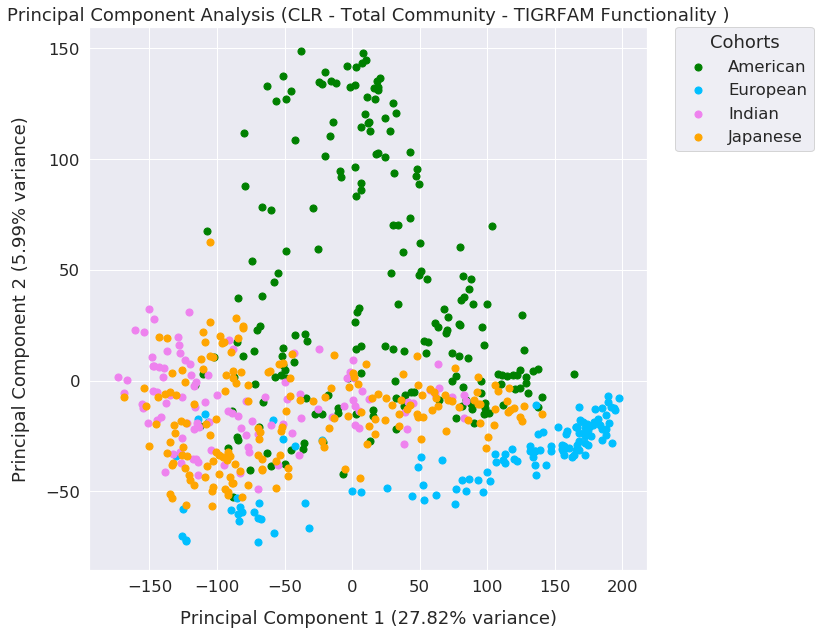

In [19]:
runPCA(clr_allCohorts_allStrains_FeatureDF_Normalized, 'allCohorts_clr_Tigrfam', 'Total Community - TIGRFAM Functionality')